In [1]:
import torch
from torchvision.models import alexnet
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings
import os
import pdb
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import itertools
import pickle
import warnings
from scipy.optimize import fmin
from scipy.stats import norm
import random
import pdb
import matplotlib.colors as mcolors
import timm
import itertools
import pandas as pd
import dill
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_model(model_name):
    activations = []

    def get_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    layers_to_extract = ['features.0', 'features.2', 'features.5', 'features.12', 'classifier.1', 'classifier.6']

    # load from checkpoint
    checkpoint = torch.load("checkpoints/alexnet_epoch_" + str(model_name) + ".pth", map_location=torch.device('cpu'))
    
    # load weights in - need to remove "module here" because of gpu parallelization (i think)
    state_dict = checkpoint['model_state_dict']
    new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

    # Recreate the AlexNet model and load weights
    model = alexnet()
    model.load_state_dict(new_state_dict)
    model.eval()

    # Retrieve additional information
    epoch = checkpoint['epoch']
    INacc = checkpoint['accuracy']
    
    # Register hooks to capture the outputs of the selected layers
    for layer_name in layers_to_extract:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(get_activation(layer_name))
    return model, activations, layers_to_extract, INacc


def preprocess_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

def load_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

# define loss function to compute scaling values
def compute_loss(params, all_combinations, biggerDiff):
    psi = params[:11]
    sigma = params[11]
    
    # make a copy here of all the combinations
    all_combinations_copy = np.copy(all_combinations)
    all_combinations_copy = all_combinations_copy/10
    
    # replace with the psi values
    for interp_val in range(11):
        all_combinations_copy[all_combinations == interp_val] = psi[interp_val]

    # calculate the differences and probabilitys
    diffs = np.abs(all_combinations_copy[:, 0] - all_combinations_copy[:, 1]) - np.abs(all_combinations_copy[:, 2] - all_combinations_copy[:, 3])
    total_prob = 0
    for response_num in range(len(diffs)):
        if biggerDiff[response_num] == 1:
            prob_response = -np.log(norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
        elif biggerDiff[response_num] == 2:
            prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
    return total_prob

# Generate all pairings of numbers from 0 to 10 without repeats
pairs = list(itertools.combinations(range(11), 2))

# Now generate all combinations of two pairs and convert to a matrix
all_combinations = np.array([a + b for a, b in itertools.combinations(pairs, 2)])

In [21]:
#which epochs do you want to look at? define here as range
model_names = [31, 70, 72, 74]

epoch:31
Optimization terminated successfully.
         Current function value: 246.824382
         Iterations: 656
         Function evaluations: 938
Optimization terminated successfully.
         Current function value: 300.197895
         Iterations: 977
         Function evaluations: 1343
Optimization terminated successfully.
         Current function value: 268.350698
         Iterations: 878
         Function evaluations: 1227
Optimization terminated successfully.
         Current function value: 613.328089
         Iterations: 932
         Function evaluations: 1307
Optimization terminated successfully.
         Current function value: 183.300207
         Iterations: 671
         Function evaluations: 945
Optimization terminated successfully.
         Current function value: 228.593890
         Iterations: 782
         Function evaluations: 1105
Optimization terminated successfully.
         Current function value: 356.834244
         Iterations: 1326
         Function evaluatio

Optimization terminated successfully.
         Current function value: 149.902597
         Iterations: 602
         Function evaluations: 854
Optimization terminated successfully.
         Current function value: 418.803622
         Iterations: 469
         Function evaluations: 680
Optimization terminated successfully.
         Current function value: 136.290090
         Iterations: 904
         Function evaluations: 1265
Optimization terminated successfully.
         Current function value: 91.343886
         Iterations: 923
         Function evaluations: 1277
Optimization terminated successfully.
         Current function value: 41.000129
         Iterations: 1064
         Function evaluations: 1458
Optimization terminated successfully.
         Current function value: 90.133883
         Iterations: 657
         Function evaluations: 917
Optimization terminated successfully.
         Current function value: 287.894526
         Iterations: 687
         Function evaluations: 970
Optim

Optimization terminated successfully.
         Current function value: 77.986165
         Iterations: 844
         Function evaluations: 1179
Optimization terminated successfully.
         Current function value: 103.347305
         Iterations: 1037
         Function evaluations: 1431
Optimization terminated successfully.
         Current function value: 23.895764
         Iterations: 683
         Function evaluations: 978
Optimization terminated successfully.
         Current function value: 89.996305
         Iterations: 497
         Function evaluations: 731
Optimization terminated successfully.
         Current function value: 61.159804
         Iterations: 1090
         Function evaluations: 1532
Optimization terminated successfully.
         Current function value: 231.756018
         Iterations: 881
         Function evaluations: 1226
Optimization terminated successfully.
         Current function value: 106.177091
         Iterations: 593
         Function evaluations: 838
Opti

Optimization terminated successfully.
         Current function value: 263.889090
         Iterations: 628
         Function evaluations: 879
Optimization terminated successfully.
         Current function value: 85.802879
         Iterations: 822
         Function evaluations: 1160
Optimization terminated successfully.
         Current function value: 118.793926
         Iterations: 731
         Function evaluations: 1032
Optimization terminated successfully.
         Current function value: 134.631622
         Iterations: 737
         Function evaluations: 1029
Optimization terminated successfully.
         Current function value: 110.066194
         Iterations: 781
         Function evaluations: 1074
Optimization terminated successfully.
         Current function value: 76.419770
         Iterations: 627
         Function evaluations: 915
Optimization terminated successfully.
         Current function value: 100.321314
         Iterations: 614
         Function evaluations: 861
Opti

Optimization terminated successfully.
         Current function value: 228.196813
         Iterations: 736
         Function evaluations: 1038
Optimization terminated successfully.
         Current function value: 257.255246
         Iterations: 761
         Function evaluations: 1066
Optimization terminated successfully.
         Current function value: 437.846074
         Iterations: 630
         Function evaluations: 890
Optimization terminated successfully.
         Current function value: 152.179587
         Iterations: 648
         Function evaluations: 924
Optimization terminated successfully.
         Current function value: 186.251766
         Iterations: 715
         Function evaluations: 1033
Optimization terminated successfully.
         Current function value: 161.425648
         Iterations: 688
         Function evaluations: 974
Optimization terminated successfully.
         Current function value: 289.017505
         Iterations: 570
         Function evaluations: 822
Opt

Optimization terminated successfully.
         Current function value: 103.017104
         Iterations: 760
         Function evaluations: 1078
Optimization terminated successfully.
         Current function value: 238.584720
         Iterations: 609
         Function evaluations: 872
Optimization terminated successfully.
         Current function value: 106.448018
         Iterations: 1183
         Function evaluations: 1637
Optimization terminated successfully.
         Current function value: 266.234533
         Iterations: 1232
         Function evaluations: 1676
Optimization terminated successfully.
         Current function value: 211.338865
         Iterations: 695
         Function evaluations: 986
Optimization terminated successfully.
         Current function value: 189.968803
         Iterations: 707
         Function evaluations: 995
Optimization terminated successfully.
         Current function value: 17.030157
         Iterations: 676
         Function evaluations: 994
Op

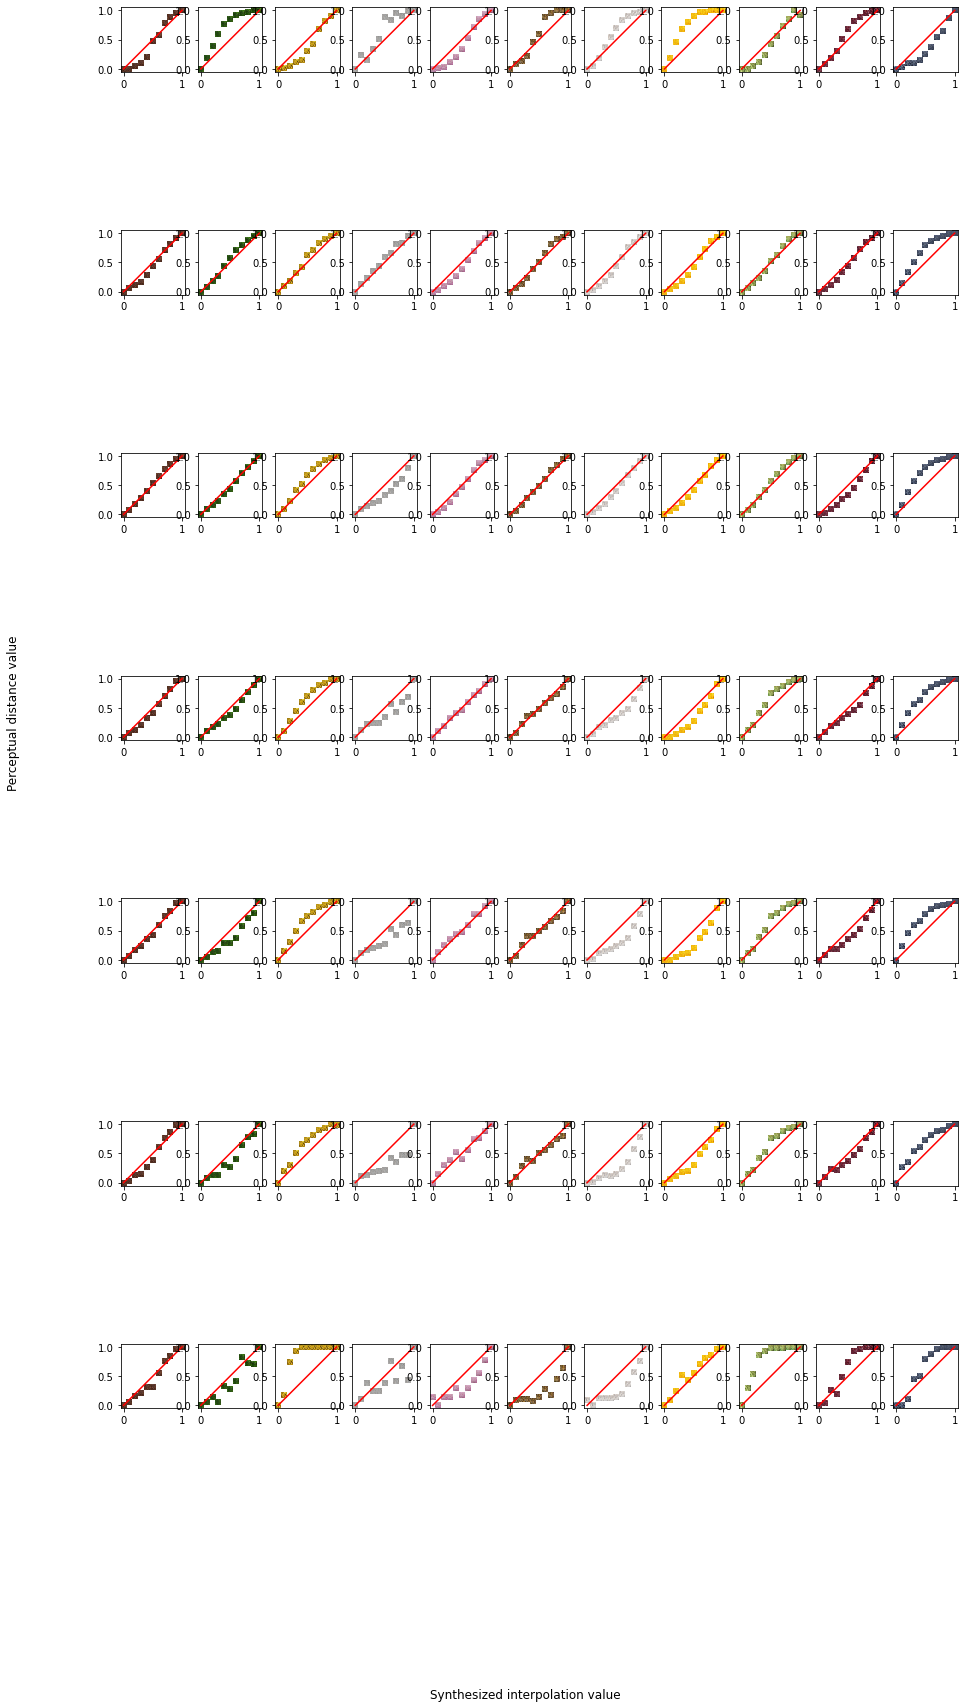

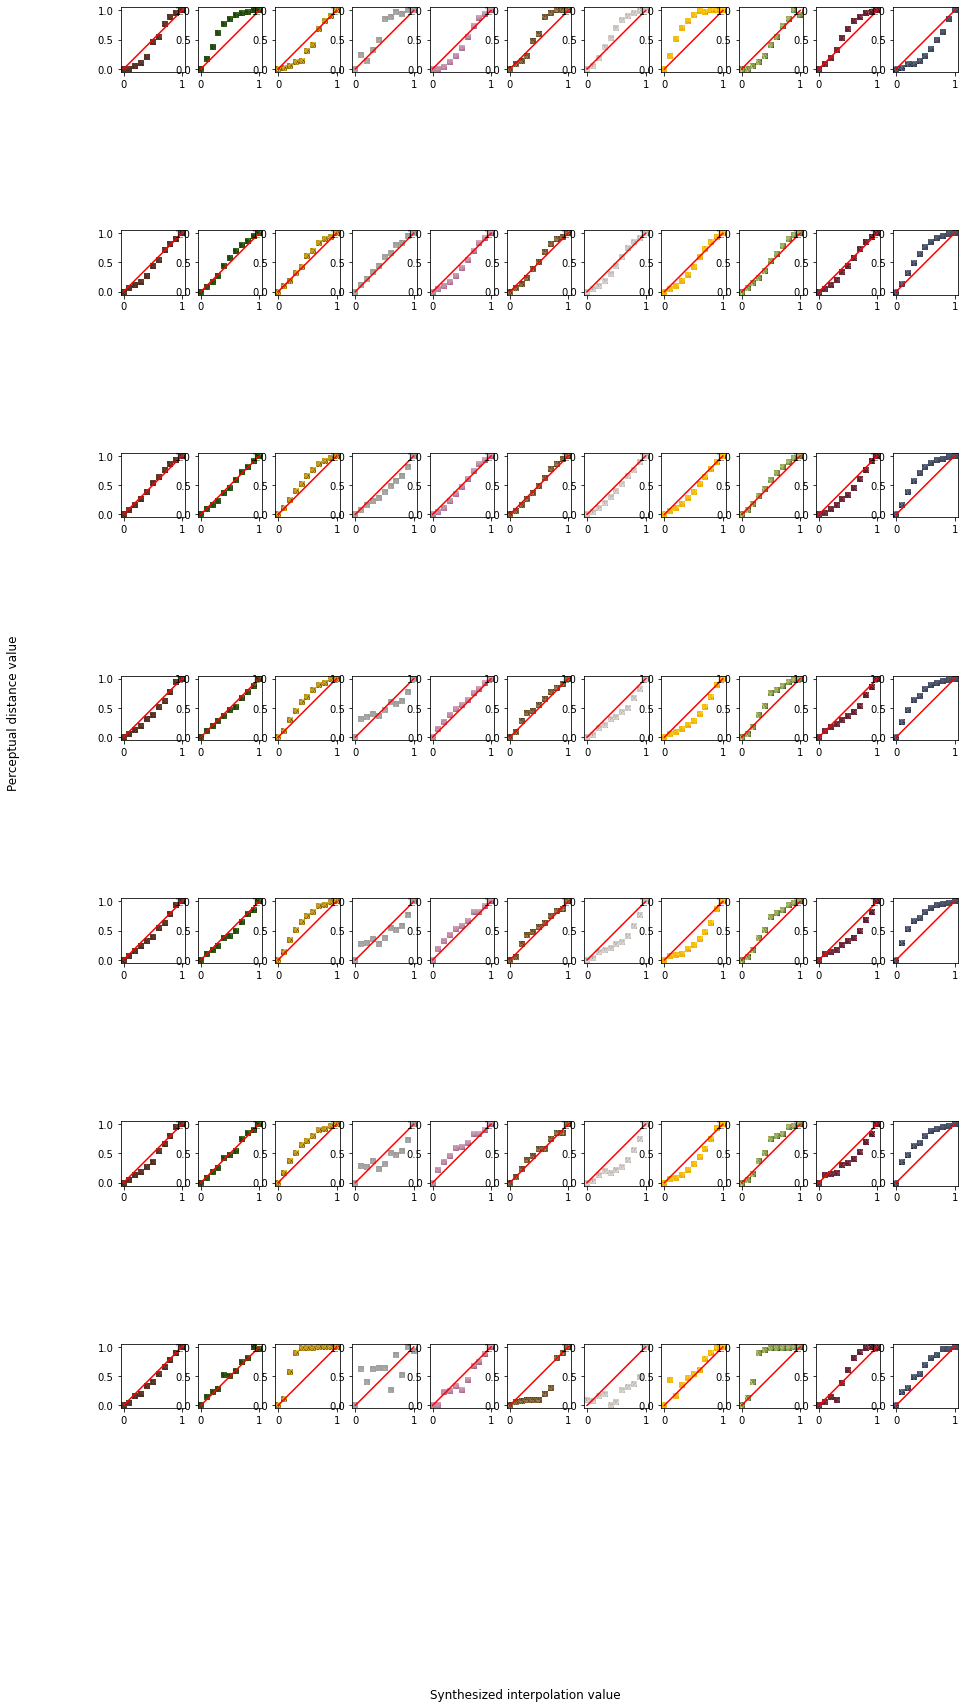

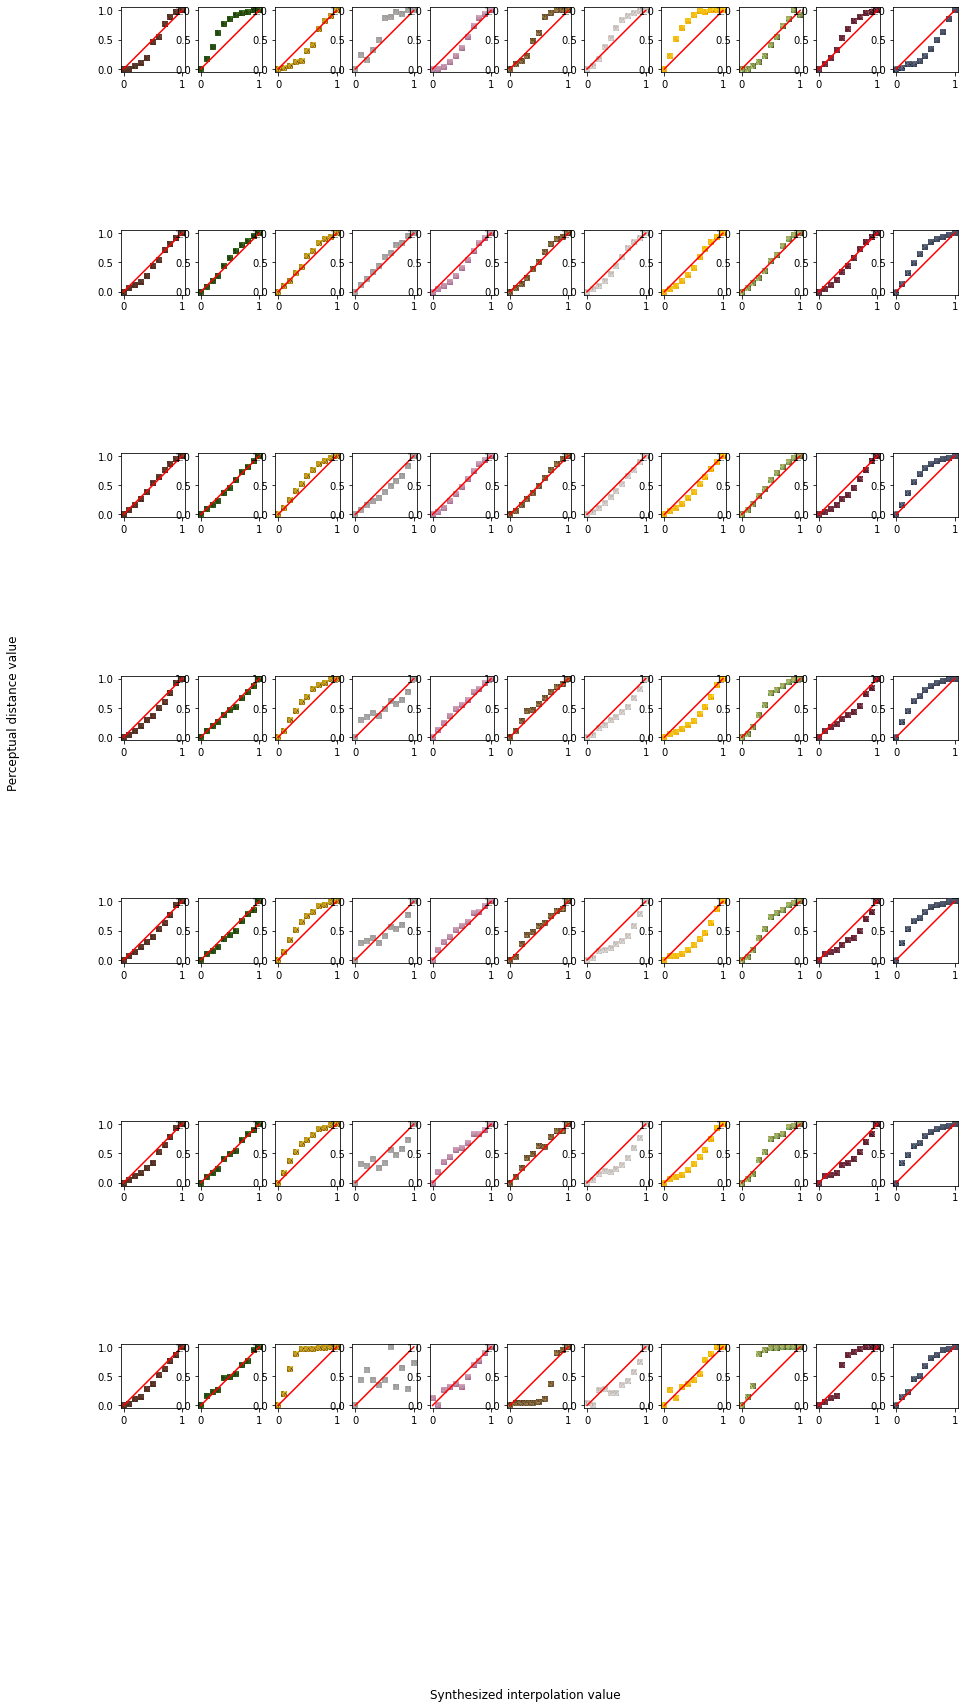

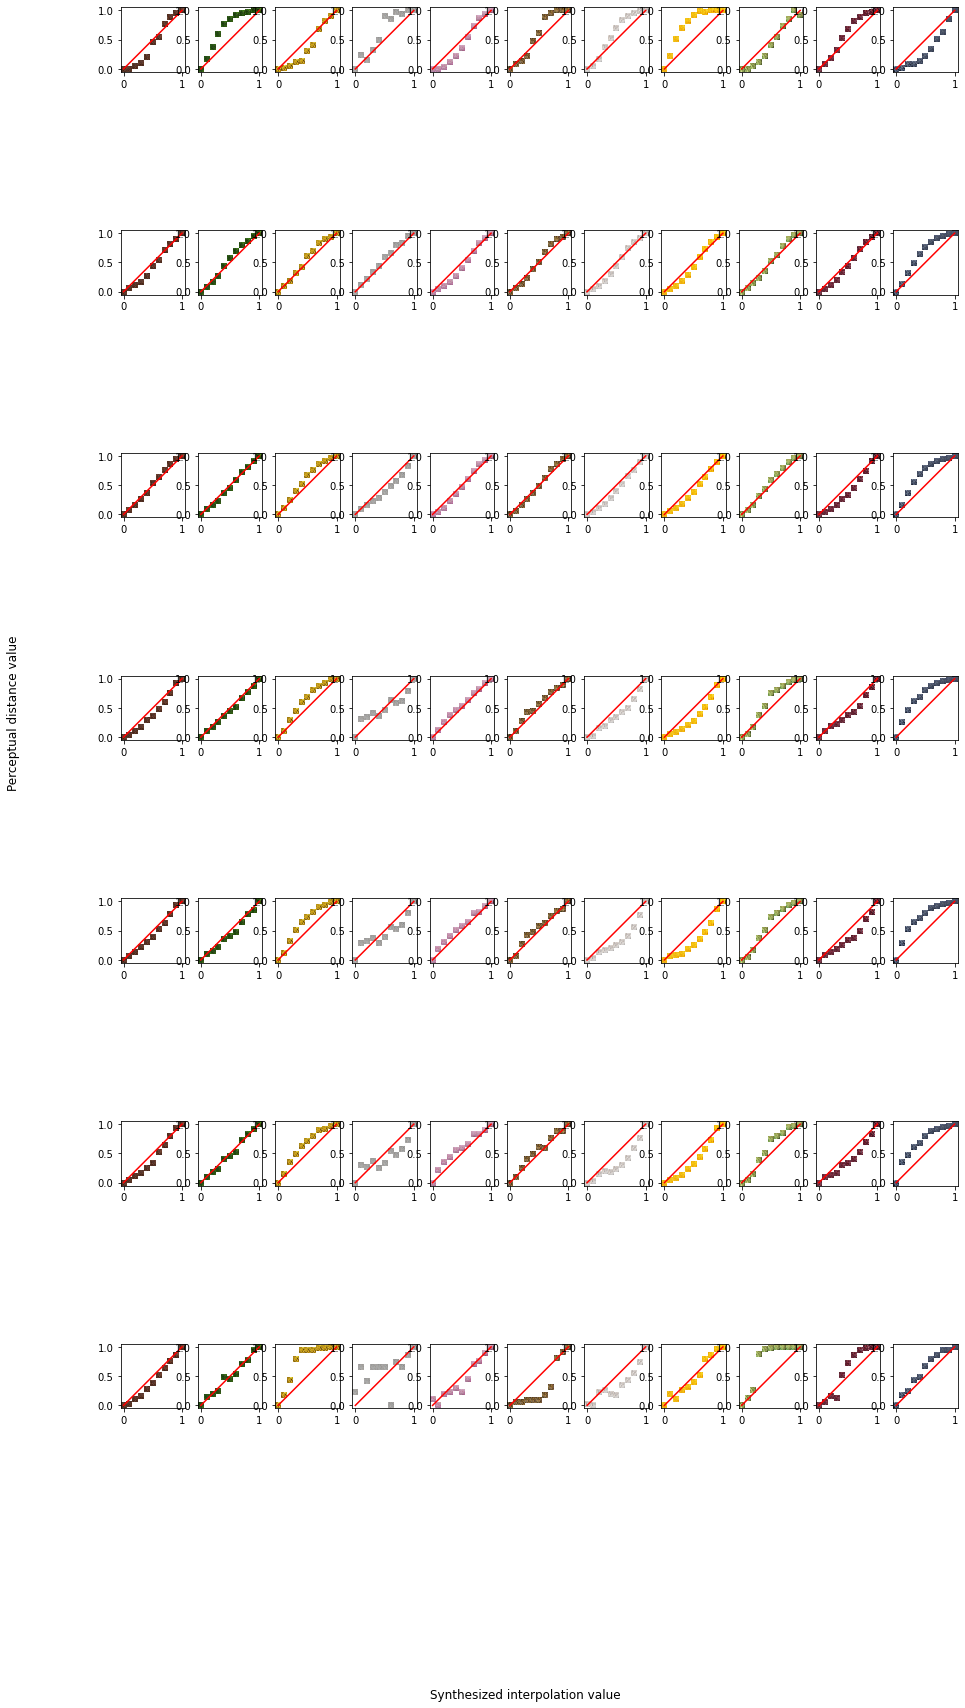

In [23]:
# if you want to wipe everything and start over, uncomment these out.
#Psis = {};
#mldsSigmas = {};
#allSpecs = {};
#allINacc = {};

#loop through all model epochs (model names)
for model_name in model_names:
    print("epoch:" + str(model_name))
    activationLoss = 0
    fade = 0
    
    # Load the model, initialize the activation hooks, and get specs/imagenet accuracy
    model, activations, layers_to_extract, INacc = get_model(model_name)
    allINacc[model_name] = INacc
    
    # Name the textures, the interpolation values, and create empty dictionaries to store things
    image1Names = ['acorns', 'grass', 'lemons', 'pebbles', 'petals', 'bees', 'iceCream', 'corn', 'guacamole', 'rubies', 'blueberries']
    image2Names = ['redwood', 'leaves', 'bananas', 'granite', 'buttercream', 'pineapple', 'gooseFeathers', 'balloons', 'brainCoral', 'cherries', 'beads']
    interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    interpNames = [f"{string1}_{string2}" for string1, string2 in zip(image1Names, image2Names)]
    allActivations = {}; allImages = {}; imageNames = []; imageIndex = 0;
    
    # Actually go through and extract all activations
    for interpName in interpNames:
        for interpValue in interpValues:
            img_path = os.path.join('out', interpName, '10x10', 
                    f"{image1Names[imageIndex]}_{interpValue}_{image2Names[imageIndex]}_10x10_pool4_smp1.png")
            imageName = f"{interpName}_{interpValue}"
            # Different name if doing activation loss images
            if activationLoss == 1:
                img_path = 'out_activations_bal/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_1x1' + '_pool4_smp1.png'
            if fade == 1:
                img_path = 'fades/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_pool4_smp1.png'
            #print(img_path)
            x = preprocess_image(img_path, 224)
            unprocessed_image = load_image(img_path, 224)
            
            # Reset activations
            activations.clear()
    
            # Forward pass through the model
            with torch.no_grad():
                model(x)
    
            # Save outputs
            allActivations[imageName] = [activation.numpy() for activation in activations]
            allImages[imageName] = unprocessed_image.squeeze(0).permute(1, 2, 0).numpy()  # Save the original image
            imageNames.append(imageName)
            
            # Add softmax as last layer and classification as final
            allActivations[imageName].append(scipy.special.softmax(allActivations[imageName][len(layers_to_extract)-1]))            
            softMaxProbs = scipy.special.softmax(allActivations[imageName][len(layers_to_extract)-1]);
            
        # Move on to next image
        imageIndex += 1


    ## now do the mlds
    # pick which layers you want to look at
    layers = range(0,len(layers_to_extract)+1)
    
    # init a figure
    fig = plt.figure(figsize=(15, 4*len(layers)))
    sub = 0;

    #create empty dicts to store psi values for each model
    Psis[model_name] = {}
    mldsSigmas[model_name] = {}

    #iterate through layers, doing mlds
    for layer in layers:
    
        # iterate through interpolations
        for interpPair in range(len(interpNames)):
            
            # make an empty list to keep track
            biggerDiff = [];
    
            # simulate the 2AFC decisions based on cosine dissimilarity between embeddings
            for pairings in all_combinations.astype(int):
                # add which interp number this is by adding amount of pairs you've iterated * num interp values
                pairings = tuple(x + interpPair*len(interpValues) for x in pairings)
                # get the index from all activations to the pairs
                im1 = pairings[0]; im2 = pairings[1]; im3 = pairings[2]; im4 = pairings[3];
                # calcuate the distances
                dist12 = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())
                dist34 = scipy.spatial.distance.cosine(allActivations[imageNames[im3]][layer].flatten(), allActivations[imageNames[im4]][layer].flatten())
                if dist12 > dist34:
                    biggerDiff.append(1)
                elif dist34 > dist12:
                    biggerDiff.append(2)
                else:
                    biggerDiff.append(0)
            
            
            # set up initial params
            psi = np.arange(0, 11)/10 #np.random.rand(11)#
            sigma = 0.2
            initial_params = np.concatenate((psi, [sigma]))
            
            # search for params
            optimal_params = fmin(compute_loss, initial_params, args=(all_combinations, biggerDiff));
            psi = optimal_params[:11]
            psi = psi - np.min(psi)
            psi = psi / np.max(psi)
    
            # save the fit parameters (psi and sigma values)
            Psis[model_name][(layer, interpPair)] = psi;
            mldsSigmas[model_name][(layer, interpPair)] = optimal_params[11];
            
            # plot it
            plt.subplot(len(layers),len(image1Names),interpPair+1+sub*len(image1Names))
            
            # iterate over interp_values
            for interp_value in range(11):
                im = interpPair * len(interpValues) + interp_value
                plt.imshow(allImages[imageNames[im]], extent=[(interp_value ) / 10 - 0.05, (interp_value) / 10 + 0.05, psi[interp_value] - 0.05, psi[interp_value] + 0.05])
           
            # set axis limits
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.plot([0, 1], [0, 1], 'r')
    
        sub += 1        
    # show the plot
    fig.supylabel('Perceptual distance value')
    fig.supxlabel('Synthesized interpolation value')
    

In [24]:
s1 = np.arange(0,32,1)
s2 = np.arange(32, 76, 2)

model_names = np.concatenate((s1,s2))

In [25]:
#dill.load_session('1119alexnet.db')
dill.dump_session('1122alexnet.db')